In [106]:
%%capture
!pip install -U langchain langchain-community langgraph langchain-anthropic

In [171]:
import os
import re
import getpass
import pandas as pd
from typing import List, Dict, Optional, Literal
from typing_extensions import TypedDict
from pathlib import Path
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

In [108]:
%%capture
!unzip -o "claude-3.5-sonnet.zip"

In [109]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Enter {var}: ")

In [110]:
_set_env("ANTHROPIC_API_KEY")

In [111]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022")

In [112]:
df = None
csv_file = None

def find_csv_file(base_path: Path) -> Path:
    csv_files = list(base_path.glob('*.csv'))
    if not csv_files:
        raise FileNotFoundError("No CSV file found in the directory")
    return csv_files[0]

In [113]:
csv_file = find_csv_file(Path("./results_local/claude-3.5-sonnet/"))
df = pd.read_csv(csv_file, delimiter=";")
base_path = Path("./results_local/claude-3.5-sonnet/")

In [114]:
@tool
def describe_dataframe() -> str:
    """
    Extracts comprehensive DataFrame information including metadata and column details.

    Returns:
        str: A structured overview of the DataFrame containing:
             - DataFrame Metadata (shape, memory usage, data types summary)
             - Column-wise Information (types, ranges, samples, null info)

    Raises:
        ValueError: If DataFrame analysis encounters any errors

    Examples:
        Assuming a DataFrame 'df' exists with sales data:
        >>> df = pd.DataFrame({
        ...     'date': ['2024-01-01', '2024-01-02'],
        ...     'sales': [100, 200],
        ...     'category': ['A', 'B']
        ... })
        >>> description = describe_dataframe()
        >>> print(description)
        DataFrame Metadata:
        - Dimensions: 2 rows × 3 columns
        - Memory Usage: 1.2 KB
        - Data Types Summary: numeric (1), categorical (1), datetime (1)
        ...
    """
    try:
        if 'df' not in globals():
            raise ValueError("DataFrame 'df' is not defined in global scope")

        if df.empty:
            raise ValueError("DataFrame is empty")

        metadata = ["DataFrame Metadata:"]

        # Basic DataFrame metadata
        rows, cols = df.shape
        metadata.append(f"- Dimensions: {rows:,} rows × {cols} columns")

        # Memory usage
        memory_usage = df.memory_usage(deep=True).sum()
        memory_str = f"{memory_usage/1024:.1f} KB" if memory_usage < 1024**2 else f"{memory_usage/1024**2:.1f} MB"
        metadata.append(f"- Memory Usage: {memory_str}")

        # Data types summary
        dtype_counts = df.dtypes.value_counts()
        dtype_summary = []

        # Count numeric columns
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
        if len(numeric_cols) > 0:
            dtype_summary.append(f"numeric ({len(numeric_cols)})")

        # Count categorical/object columns
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        if len(categorical_cols) > 0:
            dtype_summary.append(f"categorical ({len(categorical_cols)})")

        # Count datetime columns
        datetime_cols = df.select_dtypes(include=['datetime64']).columns
        if len(datetime_cols) > 0:
            dtype_summary.append(f"datetime ({len(datetime_cols)})")

        metadata.append(f"- Data Types Summary: {', '.join(dtype_summary)}")

        # Missing values summary
        total_missing = df.isna().sum().sum()
        metadata.append(f"- Total Missing Values: {total_missing:,}")

        # Column-wise information
        metadata.append("\nColumn Information:")

        for col in df.columns:
            col_memory = df[col].memory_usage(deep=True)
            col_memory_str = f"{col_memory/1024:.1f} KB" if col_memory < 1024**2 else f"{col_memory/1024**2:.1f} MB"
            non_null_pct = (df[col].count() / len(df)) * 100

            # Handle numeric columns
            if df[col].dtype in ['int64', 'float64']:
                if df[col].count() > 0:
                    min_val = df[col].min()
                    max_val = df[col].max()
                    metadata.append(
                        f"- {col} (numeric):\n"
                        f"  range: {min_val} to {max_val}\n"
                        f"  non-null: {non_null_pct:.1f}%\n"
                        f"  memory: {col_memory_str}\n"
                        f"  dtype: {df[col].dtype}"
                    )
                else:
                    metadata.append(
                        f"- {col} (numeric):\n"
                        f"  range: no non-null values\n"
                        f"  non-null: 0%\n"
                        f"  memory: {col_memory_str}\n"
                        f"  dtype: {df[col].dtype}"
                    )

            # Handle datetime columns
            elif pd.api.types.is_datetime64_any_dtype(df[col]):
                if df[col].count() > 0:
                    min_date = df[col].min()
                    max_date = df[col].max()
                    metadata.append(
                        f"- {col} (datetime):\n"
                        f"  range: {min_date.date()} to {max_date.date()}\n"
                        f"  non-null: {non_null_pct:.1f}%\n"
                        f"  memory: {col_memory_str}\n"
                        f"  dtype: {df[col].dtype}"
                    )

            # Handle categorical/text columns
            else:
                unique_vals = df[col].dropna().unique()[:5]
                sample_values = [f"'{str(val)}'" for val in unique_vals]
                total_unique = df[col].nunique()

                if len(sample_values) < total_unique:
                    sample_values.append(f"... ({total_unique} total unique values)")

                metadata.append(
                    f"- {col} ({df[col].dtype}):\n"
                    f"  distinct values: {', '.join(sample_values)}\n"
                    f"  non-null: {non_null_pct:.1f}%\n"
                    f"  memory: {col_memory_str}\n"
                    f"  dtype: {df[col].dtype}"
                )

        return "\n".join(metadata)

    except Exception as e:
        raise ValueError(f"Error analyzing DataFrame: {str(e)}")

In [115]:
@tool
def query_dataframe(query: str, columns: List[str] = None) -> str:
    """
    Filters a DataFrame using a query and extracts specified columns as a comma-separated string.

    Args:
        query (str): A pandas query string to filter the DataFrame.
                     Example: "age > 25 and city == 'New York'"
        columns (List[str], optional): List of column names to extract from the filtered DataFrame.
                                     Must be existing columns in the DataFrame.
                                     If None, all columns will be used.
                                     Example: ["name", "email", "phone"]

    Returns:
        str: A comma-separated string containing the values from the specified columns
             of the filtered DataFrame.
             Example: "John Doe, john@email.com, 123-456-7890"

    Returns:
        str: A multi-line string containing the values from the specified columns,
             with columns separated by commas and rows by newlines.
             First row contains column names.
             Example:
             "name, email, phone
              John Doe, john@email.com, 123-456-7890
              Jane Smith, jane@email.com, 987-654-3210"

    Note:
        - The query must follow pandas query syntax (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html)
        - All specified columns must exist in the DataFrame before extraction
        - Empty results will return an empty string
    """
    try:
        # Use all columns if none specified
        columns = columns if columns is not None else df.columns.tolist()

        # Validate if all requested columns exist in the DataFrame
        missing_cols = [col for col in columns if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Following columns do not exist in DataFrame: {', '.join(missing_cols)}")

        # Try to execute the query to validate its syntax
        try:
            filtered_df = df.query(query)
        except Exception as e:
            raise ValueError(f"Invalid query syntax: {str(e)}")

        # Extract specified columns
        result_df = filtered_df[columns]

        # Start with column names
        result_strings = [', '.join(columns)]

        # Add data rows
        for _, row in result_df.iterrows():
            row_values = [str(val) if pd.notna(val) else '' for val in row]
            result_strings.append(', '.join(row_values))

        return '\n'.join(result_strings)

    except Exception as e:
        raise ValueError(f"Error processing query: {str(e)}")

In [116]:
class HistoryManager:
    def __init__(self, base_path: Path = Path('results_local/claude-3.5-sonnet')):
        self.base_path = base_path
        self._history_cache: Dict[str, str] = {}
        self._is_initialized = False

    def _extract_history_content(self, markdown_content: str) -> Optional[str]:
        sections = markdown_content.split('# 2 - Instance Type')
        if len(sections) < 2:
            return None

        instance_type_section = sections[1]
        instance_steps = re.findall(r'## InstanceStep(\d+)', instance_type_section)
        if not instance_steps:
            return None

        last_step = max([int(step) for step in instance_steps])
        step_sections = instance_type_section.split(f'## InstanceStep{last_step:03d}')
        if len(step_sections) < 2:
            return None

        last_step_content = step_sections[1]
        history_sections = last_step_content.split('### History of Past Actions')
        if len(history_sections) < 2:
            return None

        history_content = history_sections[1].split('### Next Action')[0].strip()
        return history_content if history_content else None

    def _initialize_cache(self):
        if self._is_initialized:
            return

        global df
        if df is None:
            df = pd.read_csv(find_csv_file(self.base_path), delimiter=";")

        successful_traces = df[df['Success'] == 'Yes']['Folder Name'].tolist()

        for trace_folder in self.base_path.glob('*'):
            if trace_folder.name in successful_traces:
                analysis_file = trace_folder / 'experiment_analysis.md'
                if analysis_file.exists():
                    content = analysis_file.read_text(encoding='utf-8')
                    history_content = self._extract_history_content(content)
                    if history_content:
                        self._history_cache[trace_folder.name] = history_content

        self._is_initialized = True

    def get_history(self, trace_id: str) -> Optional[str]:
        self._initialize_cache()
        return self._history_cache.get(trace_id)

In [117]:
@tool
def retrieve_trace(folder_name: str) -> Optional[str]:
    """
    Retrieve the execution trace stored in a given folder.

    This function returns a structured record of actions and decisions taken
    during a specific execution.

    Args:
        folder_name (str): Name of the folder containing the trace.
                           Example format: {timestamp}_DemoAgentArgs_on_workarena.servicenow.{task}_{id}.

    Returns:
        Optional[str]: A formatted string representing the trace if found.
                       Returns None if the trace is unavailable or invalid.

    Example Output:
        #### PastAction000
        ##### Applied Reasoning
        ...

    Notes:
        The function will return None if:
        - The specified trace does not exist.
        - The execution was unsuccessful.
        - The trace data is missing.
    """
    # Use class-level caching through a singleton pattern
    if not hasattr(get_trace_history, '_manager'):
        get_trace_history._manager = HistoryManager(base_path)

    return get_trace_history._manager.get_history(folder_name)

----

### final

In [ ]:
system_message = """Objective:
Create a detailed, optimal workflow for a specified task. Your final output should be clear, actionable, and supported by data from past execution traces.

Instructions:

1. Review the Sample Workflow:
   - You will be provided with a sample workflow for a completely different task.
   - Examine this sample carefully to understand the expected structure, format, and level of detail for your output.

2. Understand the Task:
   - Focus on the specific task provided (e.g., order.ipad-pro).
   - Note any task-specific requirements or constraints mentioned.

3. Utilize Available Tools:
   - You have access to multiple tools designed to assist in gathering information.
   - Use these tools in the correct sequence to access a list of folders, where each folder contains execution traces from past instances of the task.

4. Access and Process Traces:
   - Retrieve the list of folders using the provided tools.
   - Open each folder and examine the trace files to extract key insights, steps, and data relevant to the task.
   - **Important:** Do not generate the workflow based on a single trace or one selected folder. Each folder may contain valuable and distinct information. Be explorative and integrate insights from multiple traces to form a comprehensive understanding of the task.
   - Integrate the information from each trace into your workflow draft.

5. Iterative Refinement:
   - Continuously update and refine your workflow based on the new insights from each trace.
   - After processing each folder, assess whether additional information from other traces can further optimize the workflow.
   - Repeat this process iteratively until you determine that no further improvements can be made.

6. Finalization:
   - Once you believe that all valuable insights have been incorporated and the workflow is in its optimal state, finalize the workflow.
   - Ensure that every step in the workflow is clear, actionable, and backed by data from the traces.

7. Output:
   - Provide the complete, finalized workflow as your output.

Additional Notes:
   - Be explicit in detailing each step of your process.
   - Document any assumptions or decision points briefly if needed.
   - The goal is to have a comprehensive, optimized workflow that can be directly applied to the given task."""

In [ ]:
sample_workflow = """### Workflow: Order iPad Mini from ServiceNow Catalog

1. Navigate to Hardware Category
   - Two valid approaches:
     * Action: `click(link="Hardware")`
     * Alternative: `click(link="Hardware. Order from a variety of hardware...")`
   - Location: Main catalog navigation
   - ✅ Success Pattern: Both approaches work reliably

2. Select iPad Mini
   - Action: `click(link="iPad mini")`
   - Location: "Category Items" region
   - ✅ Success Pattern: Direct link click is reliable

3. Configure Product Options
   Important: Configuration must be done in correct order!

   a. Color Selection
   - Action: `click(label="[color_option]")`
   - Available options: Pink, Purple, Space Grey, Starlight
   - ⚠️ Known Issues:
     * Direct radio button clicks often fail due to intercepting div elements
     * Use label clicks instead of direct radio input clicks
     * Ensure element is in viewport before clicking

   b. Storage Selection
   - Action: `click(label="[storage_option]")`
   - Options: 64GB (default), 256GB (+$150)
   - ⚠️ Same interaction issues as color selection
   - 💡 Best Practice: Click label element instead of radio button

4. Set Quantity
   - Action: `select(dropdown="Quantity", value=desired_number)`
   - Location: "Order this Item" section
   - ✅ Success Pattern: Dropdown interaction is reliable
   - Note: Verify selection before proceeding

5. Complete Order
   - Action: `click(button="Order Now")`
   - Location: Bottom of order form
   - ✅ Success Pattern: Button is consistently clickable
   - Validation: Order confirmation message will appear

### Critical Implementation Notes:

1. Element Interaction Strategy:
   - Prefer label/parent element clicks over direct radio inputs
   - Use proper selectors: `label`, `button`, `link` over raw element IDs
   - Handle intercepting div elements by targeting correct clickable areas

2. Viewport Management:
   - Ensure elements are fully visible before interaction
   - Scroll if needed: `scroll(0, needed_offset)`
   - Verify element interactability after scrolling

3. Error Prevention:
   - Always verify mandatory fields (color, storage) before order submission
   - Handle potential timeout errors with retry logic
   - Validate selections before proceeding to next step

4. UI Peculiarities:
   - Radio buttons have intercepting div layers
   - Some elements require scrolling into view
   - Form follows strict sequential order of configuration"""

In [ ]:
user_message = """Generate a workflow for the following task: {}.
You are provided with a sample workflow:
{}""".format("order-ipad-pro", sample_workflow)

In [172]:
# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content=system_message
                    ),
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

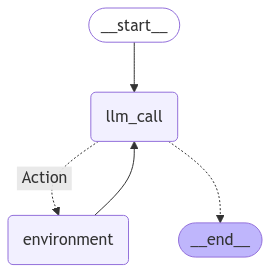

In [173]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [174]:
# Invoke
# FIXME: check if there is some way to print the intermediate steps?!
messages = [HumanMessage(content=user_message)]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Generate a workflow for the following task: order-ipad-pro. 
You are provided with a sample workflow: 
### Workflow: Order iPad Mini from ServiceNow Catalog

1. Navigate to Hardware Category
   - Two valid approaches:
     * Action: `click(link="Hardware")`
     * Alternative: `click(link="Hardware. Order from a variety of hardware...")`
   - Location: Main catalog navigation
   - ✅ Success Pattern: Both approaches work reliably

2. Select iPad Mini
   - Action: `click(link="iPad mini")`
   - Location: "Category Items" region
   - ✅ Success Pattern: Direct link click is reliable

3. Configure Product Options
   Important: Configuration must be done in correct order!

   a. Color Selection
   - Action: `click(label="[color_option]")` 
   - Available options: Pink, Purple, Space Grey, Starlight
   - ⚠️ Known Issues:
     * Direct radio button clicks often fail due to intercepting div elements
     * Use lab

----
### experiment

In [153]:
system_message = """Objective:
Create a detailed, optimal workflow for a specified task. Your final output should be clear, actionable, and supported by data from past execution traces.

Instructions:

1. Review the Sample Workflow:
   - You will be provided with a sample workflow for a completely different task.
   - Examine this sample carefully to understand the expected structure, format, and level of detail for your output.

2. Understand the Task:
   - Focus on the specific task provided (e.g., order.ipad-pro).
   - Note any task-specific requirements or constraints mentioned.

3. Utilize Available Tools:
   - You have access to multiple tools designed to assist in gathering information.
   - Use these tools in the correct sequence to access a list of folders, where each folder contains execution traces from past instances of the task.

4. Access and Process Traces:
   - Retrieve the list of folders using the provided tools.
   - Open each folder and examine the trace files to extract key insights, steps, and data relevant to the task.
   - **Important:** Do not generate the workflow based on a single trace or one selected folder. Each folder may contain valuable and distinct information. Be explorative and integrate insights from multiple traces to form a comprehensive understanding of the task.
   - Integrate the information from each trace into your workflow draft.

5. Iterative Refinement:
   - Continuously update and refine your workflow based on the new insights from each trace.
   - After processing each folder, assess whether additional information from other traces can further optimize the workflow.
   - Repeat this process iteratively until you determine that no further improvements can be made.

6. Finalization:
   - Once you believe that all valuable insights have been incorporated and the workflow is in its optimal state, finalize the workflow.
   - Ensure that every step in the workflow is clear, actionable, and backed by data from the traces.

7. Output:
   - Provide the complete, finalized workflow as your output.

Additional Notes:
   - Be explicit in detailing each step of your process.
   - Document any assumptions or decision points briefly if needed.
   - The goal is to have a comprehensive, optimized workflow that can be directly applied to the given task."""

In [154]:
sample_workflow = """### Workflow: Order iPad Mini from ServiceNow Catalog

1. Navigate to Hardware Category
   - Two valid approaches:
     * Action: `click(link="Hardware")`
     * Alternative: `click(link="Hardware. Order from a variety of hardware...")`
   - Location: Main catalog navigation
   - ✅ Success Pattern: Both approaches work reliably

2. Select iPad Mini
   - Action: `click(link="iPad mini")`
   - Location: "Category Items" region
   - ✅ Success Pattern: Direct link click is reliable

3. Configure Product Options
   Important: Configuration must be done in correct order!

   a. Color Selection
   - Action: `click(label="[color_option]")`
   - Available options: Pink, Purple, Space Grey, Starlight
   - ⚠️ Known Issues:
     * Direct radio button clicks often fail due to intercepting div elements
     * Use label clicks instead of direct radio input clicks
     * Ensure element is in viewport before clicking

   b. Storage Selection
   - Action: `click(label="[storage_option]")`
   - Options: 64GB (default), 256GB (+$150)
   - ⚠️ Same interaction issues as color selection
   - 💡 Best Practice: Click label element instead of radio button

4. Set Quantity
   - Action: `select(dropdown="Quantity", value=desired_number)`
   - Location: "Order this Item" section
   - ✅ Success Pattern: Dropdown interaction is reliable
   - Note: Verify selection before proceeding

5. Complete Order
   - Action: `click(button="Order Now")`
   - Location: Bottom of order form
   - ✅ Success Pattern: Button is consistently clickable
   - Validation: Order confirmation message will appear

### Critical Implementation Notes:

1. Element Interaction Strategy:
   - Prefer label/parent element clicks over direct radio inputs
   - Use proper selectors: `label`, `button`, `link` over raw element IDs
   - Handle intercepting div elements by targeting correct clickable areas

2. Viewport Management:
   - Ensure elements are fully visible before interaction
   - Scroll if needed: `scroll(0, needed_offset)`
   - Verify element interactability after scrolling

3. Error Prevention:
   - Always verify mandatory fields (color, storage) before order submission
   - Handle potential timeout errors with retry logic
   - Validate selections before proceeding to next step

4. UI Peculiarities:
   - Radio buttons have intercepting div layers
   - Some elements require scrolling into view
   - Form follows strict sequential order of configuration"""

In [155]:
user_message = """Generate a workflow for the following task: {}.
You are provided with a sample workflow:
{}""".format("order-ipad-pro", sample_workflow)

In [156]:
# Augment the LLM with tools
tools = [describe_dataframe, query_dataframe, retrieve_trace]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [157]:
messages = [SystemMessage(content=system_message),
            HumanMessage(content=user_message)]
results = llm_with_tools.invoke(messages)
messages.append(results)

In [158]:
results.pretty_print()

================================== Ai Message ==================================

[{'text': "I'll help create a workflow for ordering an iPad Pro. Let me gather information from available traces first.", 'type': 'text'}, {'id': 'toolu_01AJt2xRokqZwHj8Rbdjpkg6', 'input': {}, 'name': 'describe_dataframe', 'type': 'tool_use'}]
Tool Calls:
  describe_dataframe (toolu_01AJt2xRokqZwHj8Rbdjpkg6)
 Call ID: toolu_01AJt2xRokqZwHj8Rbdjpkg6
  Args:


In [159]:
messages.append(ToolMessage(content=tools_by_name[results.tool_calls[0]["name"]].invoke(results.tool_calls[0]["args"]), tool_call_id=results.tool_calls[0]["id"]))

In [160]:
results = llm_with_tools.invoke(messages)
messages.append(results)

In [161]:
results.pretty_print()

================================== Ai Message ==================================

[{'text': 'Let me query for successful iPad Pro order traces to analyze:', 'type': 'text'}, {'id': 'toolu_01YMVwVP2GGw95mvUbpxjgFY', 'input': {'query': "Task == 'order-ipad-pro' and Success == 'Yes'", 'columns': ['Folder Name']}, 'name': 'query_dataframe', 'type': 'tool_use'}]
Tool Calls:
  query_dataframe (toolu_01YMVwVP2GGw95mvUbpxjgFY)
 Call ID: toolu_01YMVwVP2GGw95mvUbpxjgFY
  Args:
    query: Task == 'order-ipad-pro' and Success == 'Yes'
    columns: ['Folder Name']


In [162]:
messages.append(ToolMessage(content=tools_by_name[results.tool_calls[0]["name"]].invoke(results.tool_calls[0]["args"]), tool_call_id=results.tool_calls[0]["id"]))

In [163]:
results = llm_with_tools.invoke(messages)
messages.append(results)

In [164]:
results.pretty_print()

================================== Ai Message ==================================

[{'text': "Let me analyze these traces to create a comprehensive workflow. I'll start with the first trace:", 'type': 'text'}, {'id': 'toolu_0116T4fg8zEZr8EqhitvRXfk', 'input': {'name': '2025-02-17_01-34-18_DemoAgentArgs_on_workarena.servicenow.order-ipad-pro_6'}, 'name': 'get_trace_history', 'type': 'tool_use'}]
Tool Calls:
  get_trace_history (toolu_0116T4fg8zEZr8EqhitvRXfk)
 Call ID: toolu_0116T4fg8zEZr8EqhitvRXfk
  Args:
    name: 2025-02-17_01-34-18_DemoAgentArgs_on_workarena.servicenow.order-ipad-pro_6


In [165]:
messages.append(ToolMessage(content=tools_by_name[results.tool_calls[0]["name"]].invoke(results.tool_calls[0]["args"]), tool_call_id=results.tool_calls[0]["id"]))

In [166]:
results = llm_with_tools.invoke(messages)
messages.append(results)

In [167]:
results.pretty_print()

================================== Ai Message ==================================

[{'text': 'Let me analyze another trace to verify and enhance the workflow:', 'type': 'text'}, {'id': 'toolu_01QHayMcSHWq1iVcmZsjeey6', 'input': {'name': '2025-02-17_01-36-04_DemoAgentArgs_on_workarena.servicenow.order-ipad-pro_27'}, 'name': 'get_trace_history', 'type': 'tool_use'}]
Tool Calls:
  get_trace_history (toolu_01QHayMcSHWq1iVcmZsjeey6)
 Call ID: toolu_01QHayMcSHWq1iVcmZsjeey6
  Args:
    name: 2025-02-17_01-36-04_DemoAgentArgs_on_workarena.servicenow.order-ipad-pro_27


In [168]:
messages.append(ToolMessage(content=tools_by_name[results.tool_calls[0]["name"]].invoke(results.tool_calls[0]["args"]), tool_call_id=results.tool_calls[0]["id"]))

In [169]:
results = llm_with_tools.invoke(messages)
messages.append(results)

In [170]:
results.pretty_print()

================================== Ai Message ==================================

Based on the analysis of multiple traces, I can now create a comprehensive workflow for ordering an iPad Pro:

### Workflow: Order iPad Pro from ServiceNow Catalog

1. Access iPad Pro Product Page
   - Action: `click(link="iPad pro")`
   - Location: "Top Requests" section of Service Catalog main page
   - ✅ Success Pattern: Direct link click is consistently reliable

2. Configure Product Options
   Important: Configuration must be done in correct order!

   a. Color Selection
   - Default: Space Grey (usually pre-selected)
   - Available Options: Space Grey, Silver
   - Action: `click(label="[color_option]")`
   - ⚠️ Known Issues:
     * Direct radio button clicks often fail due to intercepting div elements
     * Use label clicks instead of direct radio input clicks
     * Verify selection before proceeding

   b. Storage Selection
   - Action: `click(label="[storage_option]")`
   - Options: 
     * 128G